In [1]:
from ddm.data_handling import read_file
from ddm.processing import ddm_numpy #need to make sure we use the proper ddm function with dask functionality
from ddm.fitting import findMeanSqFFT_np, computeAB
from ddm.plotting import plotSingleExpFit, plotISF
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm

Begin by loading in data<br/>
Run the ddm function on the loaded dataset<br/>
From the resultant g(q, tau), determine A and B using findMeanSqFFT and computeAB - at this point move away from dask arrays.<br/>
Determine the ISF for various q values<br/>
Run fitting procedures on these with a few models and show the output<br/>

Compare to traditional particle tracking algorithms

**Loading in Data**<br/>
At this point a user input may be required if the programme detects a multi-experiment file

In [2]:
filename = '../data/test_dataset.tif'

ddmData = read_file(filename)

c:\Users\iainm\anaconda3\envs\ddm_env\lib\site-packages\pims\bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


In [3]:
ddmData.data

dask.array<_map_read_frame, shape=(3000, 512, 512), dtype=float16, chunksize=(1, 512, 512), chunktype=numpy.ndarray>

**Running the DDM Function**<br/>
This part will determine the full DDM matrix as the square of the difference between Fourier transformed frames

In [4]:
ddmData = ddmData.data
ddmData = np.asarray(ddmData)

In [5]:
intTaus = np.arange(len(ddmData)//2)
# ddmMatrix = np.array([None for j in range(len(intTaus))])
ddmMatrix = []
for tau in tqdm(intTaus):
    # ddmMatrix[tau] = ddm_numpy(ddmData, tau) #at this point we have the 0th axis as taus and the 1st axis as qs
    ddmMatrix.append(ddm_numpy(ddmData, tau))
ddmMatrix = np.asarray(ddmMatrix)

100%|██████████| 1500/1500 [9:34:58<00:00, 23.00s/it]  


**Determining A and B**

In [6]:
meanSqFFT = findMeanSqFFT_np(ddmData)
A, B = computeAB(meanSqFFT)

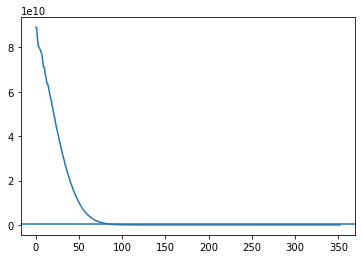

In [7]:
pl.plot(A[10:])
pl.axhline(B)

**Calculating the ISF**

In [8]:
isf = 1. - (ddmMatrix - B)/A

isf = np.transpose(isf)

To access a specific q value (in units of 1/pixels) one can use regular indexing of the 0th axis of the ISF

**Fitting/Plotting**<br/>
An example to fit and plot to a single exponential. Supported fitting functions are double exponential and the Schultz model

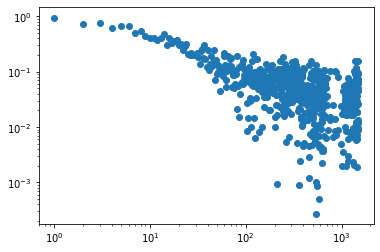

In [13]:
# taus = intTaus*ddmData.tScale #taus in milliseconds
taus = intTaus
isf[:,0] = 1.
plotISF(isf[:,:], taus[:], q = len(isf)//2)
pl.loglog()
pl.show()